<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BGoiania%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/goianiadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27141.0,27141.00000,13558.000000,13531.000000,13337.000000,41.000000,13428.000000,13294.000000,13534.000000,13572.000000,0.0
mean,83423.0,599.93368,4.495530,31.046515,18.364580,3.500000,5.000238,24.243943,62.098049,0.833783,NaN
std,0.0,600.01105,10.867799,2.668900,2.832338,3.906405,2.475886,2.076010,15.418166,0.592954,NaN
min,83423.0,0.00000,0.000000,14.000000,2.600000,0.000000,0.000000,10.240000,18.250000,0.000000,NaN
25%,83423.0,0.00000,0.000000,29.600000,16.700000,0.000000,3.100000,22.960000,50.750000,0.400000,NaN
50%,83423.0,0.00000,0.000000,31.100000,19.200000,2.200000,4.700000,24.200000,62.500000,0.833333,NaN
75%,83423.0,1200.00000,2.875000,32.700000,20.400000,6.100000,6.400000,25.520000,74.750000,1.233333,NaN
max,83423.0,1200.00000,136.600000,40.000000,25.100000,11.100000,20.400000,32.420000,100.000000,3.900000,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83423,1980-01-01,0,NaN,26.0,NaN,NaN,1.1,22.04,80.75,0.533333,NaN
1,83423,1980-01-01,1200,12.0,NaN,19.6,NaN,NaN,NaN,NaN,NaN,NaN
2,83423,1980-01-02,0,NaN,27.3,NaN,NaN,2.2,23.20,66.00,0.966667,NaN
3,83423,1980-01-02,1200,0.0,NaN,20.1,NaN,NaN,NaN,NaN,NaN,NaN
4,83423,1980-01-03,0,NaN,30.5,NaN,NaN,3.6,25.24,62.50,0.533333,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13531.000000,0.0,41.000000,13428.000000,13294.000000,13534.000000,13572.000000
mean,NaN,31.046515,NaN,3.500000,5.000238,24.243943,62.098049,0.833783
std,NaN,2.668900,NaN,3.906405,2.475886,2.076010,15.418166,0.592954
min,NaN,14.000000,NaN,0.000000,0.000000,10.240000,18.250000,0.000000
25%,NaN,29.600000,NaN,0.000000,3.100000,22.960000,50.750000,0.400000
50%,NaN,31.100000,NaN,2.200000,4.700000,24.200000,62.500000,0.833333
75%,NaN,32.700000,NaN,6.100000,6.400000,25.520000,74.750000,1.233333
max,NaN,40.000000,NaN,11.100000,20.400000,32.420000,100.000000,3.900000


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13558.000000,0.0,13337.000000,0.0,0.0,0.0,0.0,0.0
mean,4.495530,NaN,18.364580,NaN,NaN,NaN,NaN,NaN
std,10.867799,NaN,2.832338,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,2.600000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,16.700000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,19.200000,NaN,NaN,NaN,NaN,NaN
75%,2.875000,NaN,20.400000,NaN,NaN,NaN,NaN,NaN
max,136.600000,NaN,25.100000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,26.0,NaN,1.1,22.04,80.75,0.533333
1980-01-02,27.3,NaN,2.2,23.20,66.00,0.966667
1980-01-03,30.5,NaN,3.6,25.24,62.50,0.533333
1980-01-04,32.2,NaN,4.6,25.74,56.25,0.000000
1980-01-05,32.2,NaN,5.5,25.62,62.75,1.133333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,12.0,19.6
1980-01-02,0.0,20.1
1980-01-03,0.0,20.1
1980-01-04,0.0,18.7
1980-01-05,0.0,19.5


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,26.0,NaN,1.1,22.04,80.75,0.533333,12.0,19.6
1980-01-02,27.3,NaN,2.2,23.20,66.00,0.966667,0.0,20.1
1980-01-03,30.5,NaN,3.6,25.24,62.50,0.533333,0.0,20.1
1980-01-04,32.2,NaN,4.6,25.74,56.25,0.000000,0.0,18.7
1980-01-05,32.2,NaN,5.5,25.62,62.75,1.133333,0.0,19.5


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13531.000000,41.000000,13428.000000,13294.000000,13534.000000,13572.000000,13558.000000,13337.000000
mean,31.046515,3.500000,5.000238,24.243943,62.098049,0.833783,4.495530,18.364580
std,2.668900,3.906405,2.475886,2.076010,15.418166,0.592954,10.867799,2.832338
min,14.000000,0.000000,0.000000,10.240000,18.250000,0.000000,0.000000,2.600000
25%,29.600000,0.000000,3.100000,22.960000,50.750000,0.400000,0.000000,16.700000
50%,31.100000,2.200000,4.700000,24.200000,62.500000,0.833333,0.000000,19.200000
75%,32.700000,6.100000,6.400000,25.520000,74.750000,1.233333,2.875000,20.400000
max,40.000000,11.100000,20.400000,32.420000,100.000000,3.900000,136.600000,25.100000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,26.0,NaN,1.1,22.04,80.75,0.533333,12.0,19.6
1980-01-02,27.3,NaN,2.2,23.20,66.00,0.966667,0.0,20.1
1980-01-03,30.5,NaN,3.6,25.24,62.50,0.533333,0.0,20.1
1980-01-04,32.2,NaN,4.6,25.74,56.25,0.000000,0.0,18.7
1980-01-05,32.2,NaN,5.5,25.62,62.75,1.133333,0.0,19.5


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,NaN,1.1,22.04,80.75,0.533333,12.0,19.6
1980-01-02,NaN,2.2,23.20,66.00,0.966667,0.0,20.1
1980-01-03,NaN,3.6,25.24,62.50,0.533333,0.0,20.1
1980-01-04,NaN,4.6,25.74,56.25,0.000000,0.0,18.7
1980-01-05,NaN,5.5,25.62,62.75,1.133333,0.0,19.5


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    26.0
1980-01-02    27.3
1980-01-03    30.5
1980-01-04    32.2
1980-01-05    32.2
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,41.000000,13388.000000,13293.000000,13506.000000,13531.000000,13516.000000,13299.000000
mean,-0.369369,-0.509753,0.262726,0.072818,-0.572453,-0.934156,0.401534
std,0.703857,0.242727,0.187176,0.377088,0.303937,0.159241,0.251860
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-0.696078,0.146979,-0.204893,-0.794872,-1.000000,0.253333
50%,-0.603604,-0.539216,0.258792,0.082569,-0.572650,-1.000000,0.475556
75%,0.099099,-0.372549,0.377818,0.382263,-0.367522,-0.958638,0.582222
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13531, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 711.2875 - mean_absolute_error: 26.4181
Epoch 2/200
 - 1s - loss: 384.1586 - mean_absolute_error: 19.3367
Epoch 3/200
 - 1s - loss: 192.7069 - mean_absolute_error: 13.5350
Epoch 4/200
 - 1s - loss: 83.1247 - mean_absolute_error: 8.6366
Epoch 5/200
 - 1s - loss: 30.1543 - mean_absolute_error: 4.8778
Epoch 6/200
 - 1s - loss: 11.3991 - mean_absolute_error: 2.7401
Epoch 7/200
 - 1s - loss: 7.4942 - mean_absolute_error: 2.1063
Epoch 8/200
 - 1s - loss: 7.1574 - mean_absolute_error: 2.0370
Epoch 9/200
 - 1s - loss: 7.1498 - mean_absolute_error: 2.0346
Epoch 10/200
 - 1s - loss: 7.1487 - mean_absolute_error: 2.0346
Epoch 11/200
 - 1s - loss:

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.271824, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.271824 (0.038993) {'batch_size': 10, 'camadas': 2, 'units': 7}


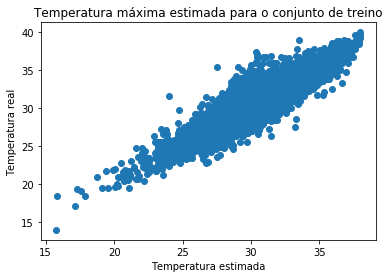

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.91075486]
 [0.91075486 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

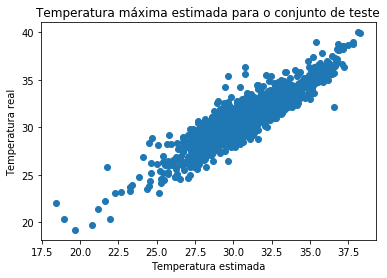

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.91139679]
 [0.91139679 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.853511422634829


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.2640045507583055


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,26.0,NaN,1.1,22.04,80.75,0.533333,12.0
1980-01-02,27.3,NaN,2.2,23.20,66.00,0.966667,0.0
1980-01-03,30.5,NaN,3.6,25.24,62.50,0.533333,0.0
1980-01-04,32.2,NaN,4.6,25.74,56.25,0.000000,0.0
1980-01-05,32.2,NaN,5.5,25.62,62.75,1.133333,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    19.6
1980-01-02    20.1
1980-01-03    20.1
1980-01-04    18.7
1980-01-05    19.5
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13299.000000,41.000000,13203.000000,13289.000000,13310.000000,13337.000000,13326.000000
mean,0.312066,-0.369369,-0.509522,0.262719,0.072012,-0.568926,-0.934161
std,0.204925,0.703857,0.242756,0.187174,0.377021,0.303512,0.158970
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.200000,-1.000000,-0.696078,0.146979,-0.204893,-0.777778,-1.000000
50%,0.315385,-0.603604,-0.539216,0.258792,0.082569,-0.572650,-1.000000
75%,0.438462,0.099099,-0.372549,0.377818,0.376147,-0.367522,-0.957540
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13337, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 207.3089 - mean_absolute_error: 13.9225
Epoch 2/200
 - 1s - loss: 68.8368 - mean_absolute_error: 7.7197
Epoch 3/200
 - 1s - loss: 21.2680 - mean_absolute_error: 4.0629
Epoch 4/200
 - 1s - loss: 9.5649 - mean_absolute_error: 2.6413
Epoch 5/200
 - 1s - loss: 8.1697 - mean_absolute_error: 2.3230
Epoch 6/200
 - 1s - loss: 8.1157 - mean_absolute_error: 2.2802
Epoch 7/200
 - 1s - loss: 8.1163 - mean_absolute_error: 2.2802
Epoch 8/200
 - 1s - loss: 8.1160 - mean_absolute_error: 2.2779
Epoch 9/200
 - 1s - loss: 5.5666 - mean_absolute_error: 1.8587
Epoch 10/200
 - 1s - loss: 2.1737 - mean_absolute_error: 1.1486
Epoch 11/200
 - 1s - loss: 1.5341 - mean_absolute_error: 0.9561
Epoch 12/200
 - 1s - loss: 1.3537 - mean_absolute_error: 0.8961
Epoch 13/200
 - 1s - loss

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.141980, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.141980 (0.021183) {'batch_size': 10, 'camadas': 2, 'units': 7}


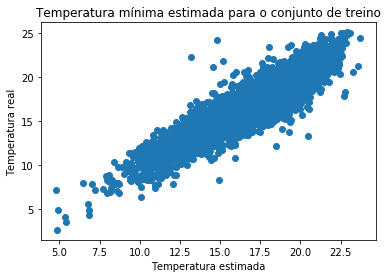

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.92946252]
 [0.92946252 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

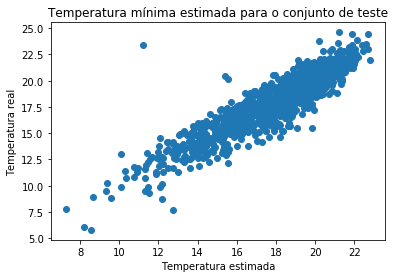

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.91715513]
 [0.91715513 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.8341947436868876


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.2436445224951231


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaGoiania.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaGoiania.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))